In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = pd.read_csv("Gemini_1INCHUSD_1h.csv", parse_dates = True, index_col = ['date'])
df = df[['open', 'high', 'low', 'close', 'Volume USD']]

In [3]:
df.head(n=5)

,open,high,low,close,Volume USD
date,,,,,
2022-04-27 00:00:00,1.2871,1.2932,1.2865,1.2888,552.689323
2022-04-26 23:00:00,1.2968,1.2970,1.2589,1.2871,1531.043637
2022-04-26 22:00:00,1.3093,1.3124,1.2961,1.2968,1661.579389
2022-04-26 21:00:00,1.2981,1.3116,1.2959,1.3093,3756.194249
2022-04-26 20:00:00,1.3053,1.3095,1.2900,1.2981,2705.407620


(1572, 5) (393, 5)
(1572, 5) (393, 5)


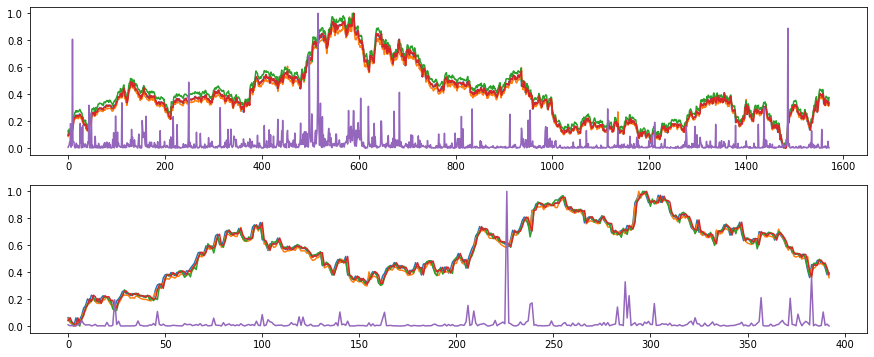

In [4]:
from sklearn.preprocessing import MinMaxScaler

test_size = int(0.8 * len(df))

train = df.iloc[:test_size]
test = df.iloc[test_size:]

print(train.shape, test.shape)

scaler = MinMaxScaler(feature_range = (0, 1))
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.fit_transform(test)
print(train_scaled.shape, test_scaled.shape)

fig, ax = plt.subplots(2, 1, figsize = (15, 6))
ax[0].plot(train_scaled)
ax[1].plot(test_scaled)

In [5]:
def training_split(df_scaled, steps):
    X_train, y_train = [], []
    for i in range(steps, df_scaled.shape[0] - steps):
        X_train.append(df_scaled[i - steps:i, :])
        y_train.append(df_scaled[i, :])
    X_train, y_train = np.array(X_train), np.array(y_train)
    return X_train, y_train

def forecasting_split(y, n_lookback, n_forecast):
    X_train, y_train = [], []
    for i in range(n_lookback, len(y) - n_forecast + 1):
        X_train.append(y[i - n_lookback:i])
        y_train.append(y[i: i + n_forecast])
    X_train, y_train = np.array(X_train), np.array(y_train)
    return X_train, y_train

X_train, y_train = training_split(train_scaled, 50)
X_test, y_test = training_split(test_scaled, 50)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1472, 50, 5) (1472, 5) (293, 50, 5) (293, 5)


In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(50, return_sequences = True, input_shape = (X_train.shape[1], 1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(50, return_sequences = True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(50, return_sequences = True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5)
])

inputs = tf.keras.Input(shape = (X_train.shape[1], 5))
x = tf.keras.layers.LSTM(50, return_sequences = True)(inputs)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.LSTM(50, return_sequences = True)(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.LSTM(50, return_sequences = True)(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.LSTM(50)(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(5)(x)
model_func = tf.keras.Model(inputs = inputs, outputs = outputs)

In [9]:
import os

def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath = os.path.join(save_path, model_name), 
                                            verbose = 0, 
                                            save_best_only = True) 

model_func.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_func.fit(X_train, y_train, epochs=100, verbose=0, batch_size=128,
            callbacks=[create_model_checkpoint(model_name = model_func.name)])

In [ ]:
class Preprocessing():

    def __init__(self, steps, df_scaled, n_lookback, n_forecast):
        self.steps = steps
        self.df_scaled = df_scaled
        self.n_lookback = n_lookback
        self.n_forecast = n_forecast

    def training_scaled(steps, df_scaled):
        X_train, y_train = [], []

        for i in range(steps, df_scaled.shape[0] - steps):
            X_train.append(df_scaled[i - steps:i, :])
            y_train.append(df_scaled[i, :])
        X_train, y_train = np.array(X_train), np.array(y_train)
        return X_train, y_train

    def forecast_split(y, n_lookback, n_forecast):
        X_train, y_train

        for i in range(n_lookback, len(y) - n_forecast + 1):
            X_train.append(y[i - n_lookback: i])
            y_train.append(y[i: i + n_forecast])
        X_train, y_train = np.array(X_train), np.array(y_train)
        return X_train, y_train